In [1]:
!pip install piqa
import os
import pandas as pd
import numpy as np
import torch
import wandb
import math
import cv2
import time
from skimage.transform import resize
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset,DataLoader
#from torchvision.transforms import Resize,ToTensor,  Compose, InterpolationMode,Normalize,RandomHorizontalFlip,RandomVerticalFlip,RandomCrop
import torch.optim as optim
from albumentations.pytorch import ToTensorV2
import albumentations as A
from torch.optim.lr_scheduler import StepLR
import random
from PIL import Image
from torchsummary import summary
import pytorch_lightning as pl 
from tqdm import tqdm
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning import Trainer
from piqa import SSIM
from pytorch_lightning.loggers import TensorBoardLogger

DEPRECATION: Loading egg at c:\programdata\anaconda3\lib\site-packages\vboxapi-1.0-py3.12.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation.. Discussion can be found at https://github.com/pypa/pip/issues/12330


Defaulting to user installation because normal site-packages is not writeable


C:\Users\ADMIN\AppData\Roaming\Python\Python312\site-packages\albumentations\__init__.py:24: UserWarning: A new version of Albumentations is available: 2.0.8 (you have 1.4.21). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [2]:
data_dir="data/"
train_dir=data_dir+"train"
test_dir=data_dir+"test"

In [3]:
class DeblurDataset(Dataset):
    def __init__(self, data, transform=None):
        self.data = data  
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        blur_path, sharp_path = self.data[idx]
        try:
            # Load images with PIL
            blur_img = Image.open(blur_path).convert("RGB")
            sharp_img = Image.open(sharp_path).convert("RGB")
            
            # Convert PIL images to numpy arrays for Albumentations
            blur_img = np.array(blur_img)
            sharp_img = np.array(sharp_img)
            
            # Apply transforms
            if self.transform:
                augmented = self.transform(image=blur_img, target=sharp_img)
                blur_img = augmented["image"].float() / 255.0  # Ensure float32
                sharp_img = augmented["target"].float() / 255.0 # Ensure float32
            else:
                # Manual conversion if no transform
                blur_img = torch.tensor(blur_img, dtype=torch.float32).permute(2, 0, 1) / 255.0
                sharp_img = torch.tensor(sharp_img, dtype=torch.float32).permute(2, 0, 1) / 255.0
            
            return blur_img, sharp_img
        except Exception as e:
            print(f"Error loading image pair {idx}: blur={blur_path}, sharp={sharp_path}, error={e}")
            raise
class DeblurDataModule(pl.LightningDataModule):
    def __init__(self,data_dir,batch_size,seed=100):
        super().__init__()
        self.save_hyperparameters()  # Save hyperparameters for logging
        self.data_dir=data_dir
        self.batch_size=batch_size
        self.seed=seed
    def split_data(self):
        random.seed(self.seed)
        
        # Define directories
        train_blur_dir = os.path.join(self.data_dir, "train/blur")
        train_sharp_dir = os.path.join(self.data_dir, "train/sharp")
        test_blur_dir = os.path.join(self.data_dir, "test/blur")
        test_sharp_dir = os.path.join(self.data_dir, "test/sharp")
        
        # Get lists of files with full paths and ensure they are sorted
        blur_files = [os.path.join(train_blur_dir, f) for f in sorted(os.listdir(train_blur_dir))]
        sharp_files = [os.path.join(train_sharp_dir, f) for f in sorted(os.listdir(train_sharp_dir))]
        
        # Ensure the number of blur and sharp images match
        assert len(blur_files) == len(sharp_files), "Mismatch between blur and sharp image counts"
        
        # Create paired list of tuples with full paths
        temp_train_data = list(zip(blur_files, sharp_files))
        
        # Get test data with full paths
        test_blur_files = [os.path.join(test_blur_dir, f) for f in sorted(os.listdir(test_blur_dir))]
        test_sharp_files = [os.path.join(test_sharp_dir, f) for f in sorted(os.listdir(test_sharp_dir))]
        assert len(test_blur_files) == len(test_sharp_files), "Mismatch in test data"
        test_data = list(zip(test_blur_files, test_sharp_files))
        
        # Split train data into train and validation (80% train, 20% validation)
        train_data = random.sample(temp_train_data, k=int(0.8 * len(temp_train_data)))
        
        # Validation data: remaining items not in train_data
        val_data = [pair for pair in temp_train_data if pair not in train_data]
        
        return train_data, val_data, test_data
    def setup(self, stage=None):
        train_data, val_data, test_data = self.split_data()
        train_transform = A.Compose([
            A.RandomCrop(height=256, width=256), 
            A.HorizontalFlip(p=0.3),
            A.VerticalFlip(p=0.3),
            A.RandomRotate90(p=0.3),
            ToTensorV2()
        ], additional_targets={"target": "image"})
        test_transform = A.Compose([
            ToTensorV2()
        ], additional_targets={"target": "image"})
        if stage == "fit" or stage is None:
            self.train_dataset = DeblurDataset(train_data, train_transform)
            self.val_dataset = DeblurDataset(val_data, test_transform)
        if stage == "test" or stage is None:
            self.test_dataset = DeblurDataset(test_data, test_transform)
    def train_dataloader(self):
        return DataLoader(self.train_dataset,batch_size=self.batch_size,shuffle=True,num_workers=3)
    def val_dataloader(self):
        return DataLoader(self.val_dataset,batch_size=self.batch_size,shuffle=False,num_workers=3)
    def test_dataloader(self):
        return DataLoader(self.test_dataset,batch_size=self.batch_size,shuffle=False)

In [4]:
class SSIMLoss(SSIM):
    def forward(self, x, y):
        return 1. - super().forward(x, y)
class DeblurAdvancedUnet(pl.LightningModule):
    def __init__(self, model, lr=1e-4, use_combined_loss=True):
        super().__init__()
        self.model = model
        self.lr = lr
        self.use_combined_loss = use_combined_loss
        self.mse_loss = nn.MSELoss()
        self.ssim_loss=SSIMLoss()
        self.w1 = 0.001  # Trade-off parameter for SSIM

    def compute_loss(self, preds, targets):
        mse = self.mse_loss(preds, targets)
        ssim_loss = self.ssim_loss(preds, targets)
        if self.use_combined_loss:
            return mse + self.w1 * ssim_loss
        return mse
    def forward(self, x):
        return self.model(x)
    def training_step(self, batch, batch_idx):
        inputs, targets = batch
        preds = self.model(inputs)
        preds=torch.clamp(preds,0.0,1.0)
        loss = self.compute_loss(preds, targets)
        self.log("train_loss", loss, prog_bar=True,on_epoch=True,on_step=False)
        return loss

    def validation_step(self, batch, batch_idx):
        inputs, targets = batch
        preds = self.model(inputs)
        preds=torch.clamp(preds,0.0,1.0)
        loss = self.compute_loss(preds, targets)
        self.log("val_loss", loss, prog_bar=True,on_epoch=True,on_step=False)
        return loss

    def configure_optimizers(self):
        optimizer=torch.optim.Adam(self.parameters(), lr=self.lr,betas=(0.9, 0.999))
        #scheduler = StepLR(optimizer, step_size=500, gamma=0.5)
        return [optimizer]#,[scheduler]

In [5]:
class DepthwiseSeparableConv(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1, use_bn=True, use_activation=True):
        super(DepthwiseSeparableConv, self).__init__()
        self.depthwise = nn.Conv2d(in_channels, in_channels, kernel_size=kernel_size, groups=in_channels, stride=stride, padding=padding, bias=False)
        self.pointwise = nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False)
        
        self.use_bn = use_bn
        if self.use_bn:
            self.bn = nn.BatchNorm2d(out_channels)
        
        self.use_activation = use_activation
        if self.use_activation:
            self.activation = nn.LeakyReLU(negative_slope=0.2, inplace=True)

    def forward(self, x):
        x = self.depthwise(x)
        x = self.pointwise(x)
        if self.use_bn:
            x = self.bn(x)
        if self.use_activation:
            x = self.activation(x)
        return x

class ResidualDSConvBlock(nn.Module):
    def __init__(self, channels):
        super(ResidualDSConvBlock, self).__init__()
        # The DSC already has activation. For residual blocks, sometimes activation is only at the end.
        # Let's assume the paper's Figure 3 implies activation within DSCs.
        self.conv1 = DepthwiseSeparableConv(channels, channels, kernel_size=3, padding=1)
        self.conv2 = DepthwiseSeparableConv(channels, channels, kernel_size=3, padding=1, use_activation=False) # No activation before sum
        self.activation = nn.LeakyReLU(negative_slope=0.2, inplace=True)

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.conv2(out) # No ReLU here from conv2
        out = out + residual
        return self.activation(out) # Activation after sum

class HaarDownsample(nn.Module):
    """
    Implements a simple Haar wavelet downsampling.
    Splits each channel into four subbands and concatenates along channel dimension.
    """
    def __init__(self):
        super(HaarDownsample, self).__init__()
        ll_coeff = torch.tensor([[1, 1], [1, 1]], dtype=torch.float32).unsqueeze(0).unsqueeze(0) / 2.0
        lh_coeff = torch.tensor([[-1, -1], [1, 1]], dtype=torch.float32).unsqueeze(0).unsqueeze(0) / 2.0
        hl_coeff = torch.tensor([[-1, 1], [-1, 1]], dtype=torch.float32).unsqueeze(0).unsqueeze(0) / 2.0
        hh_coeff = torch.tensor([[1, -1], [-1, 1]], dtype=torch.float32).unsqueeze(0).unsqueeze(0) / 2.0
        
        self.register_buffer("ll_filt", ll_coeff)
        self.register_buffer("lh_filt", lh_coeff)
        self.register_buffer("hl_filt", hl_coeff)
        self.register_buffer("hh_filt", hh_coeff)

    def forward(self, x):
        B, C, H, W = x.shape
        outputs = []
        for filt_coeff in [self.ll_filt, self.lh_filt, self.hl_filt, self.hh_filt]:
            filt = filt_coeff.repeat(C, 1, 1, 1)
            out = F.conv2d(x, filt, stride=2, padding=0, groups=C)
            outputs.append(out)
        return torch.cat(outputs, dim=1)

class InverseHaarUpsample(nn.Module):
    """
    Inverse Haar Transform that recombines subbands into an upsampled feature map
    using transposed convolutions with the Haar synthesis filters (which are the
    same as analysis filters for Haar, up to scaling).
    This aims to be the mathematical inverse of HaarDownsample.
    """
    def __init__(self):
        super(InverseHaarUpsample, self).__init__()
        # Using the same (scaled) filters as in HaarDownsample
        # These act as synthesis filters here.
        ll_coeff = torch.tensor([[1, 1], [1, 1]], dtype=torch.float32).unsqueeze(0).unsqueeze(0) / 2.0
        lh_coeff = torch.tensor([[-1, -1], [1, 1]], dtype=torch.float32).unsqueeze(0).unsqueeze(0) / 2.0
        hl_coeff = torch.tensor([[-1, 1], [-1, 1]], dtype=torch.float32).unsqueeze(0).unsqueeze(0) / 2.0
        hh_coeff = torch.tensor([[1, -1], [-1, 1]], dtype=torch.float32).unsqueeze(0).unsqueeze(0) / 2.0

        self.register_buffer("ll_filt_inv", ll_coeff)
        self.register_buffer("lh_filt_inv", lh_coeff)
        self.register_buffer("hl_filt_inv", hl_coeff)
        self.register_buffer("hh_filt_inv", hh_coeff)
        

    def forward(self, x):
        B, C4, H_in, W_in = x.shape # C4 = 4 * C_original
        C = C4 // 4

        # Split the input into the four subbands
        # Order must match the concatenation order in HaarDownsample
        subbands = torch.split(x, C, dim=1) # List of 4 tensors, each (B, C, H_in, W_in)

        reconstructed_components = []
        inv_filters = [self.ll_filt_inv, self.lh_filt_inv, self.hl_filt_inv, self.hh_filt_inv]
        for i in range(4):
            subband_coeff = subbands[i] # (B, C, H_in, W_in)
            filt_coeff = inv_filters[i] # (1, 1, 2, 2)

            # Weight for conv_transpose2d: (in_channels, out_channels/groups, kH, kW)
            # Here, in_channels = C, out_channels = C, groups = C
            # So, weight shape should be (C, 1, 2, 2)
            filt_for_conv_transpose = filt_coeff.repeat(C, 1, 1, 1)

            # Apply transposed convolution to upsample and filter
            # The stride=2 in conv_transpose2d upsamples
            component = F.conv_transpose2d(subband_coeff, filt_for_conv_transpose,
                                           stride=2, padding=0, groups=C)
            reconstructed_components.append(component)

        # Sum the contributions from all subbands
        # The scaling of the filters (divided by 2 in definition) ensures that
        # summing them up achieves the correct reconstruction magnitude.
        # Each filter had energy 1 (0.5^2 * 4 = 1). The sum of 4 such components should reconstruct.
        output = torch.stack(reconstructed_components, dim=0).sum(dim=0)

        return output
class ChannelAttention(nn.Module):
    def __init__(self, in_channels, reduction_ratio=16):
        super(ChannelAttention, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)
        
        hidden_channels = max(1, in_channels // reduction_ratio) # Ensure hidden_channels is at least 1

        self.shared_mlp = nn.Sequential(
            nn.Conv2d(in_channels, hidden_channels, kernel_size=1, bias=False),
            nn.LeakyReLU(negative_slope=0.2, inplace=True), # Paper uses LeakyReLU
            nn.Conv2d(hidden_channels, in_channels, kernel_size=1, bias=False)
        )
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = self.shared_mlp(self.avg_pool(x))
        max_out = self.shared_mlp(self.max_pool(x))
        attention = self.sigmoid(avg_out + max_out)
        return x * attention
class MRFC_Block(nn.Module):
    """
    Implements one Multireceptive Field Channel Block.
    REVISED INTERPRETATION: R is formed by concatenating an initial 1x1 processed input
    with the outputs of the four dilated branches, leading to 5C channels for R.
    """
    def __init__(self, in_channels, # This is the 'C_base' if the 5C interpretation holds
                       # inter_channels_per_branch, # This will now be 'in_channels' or 'C_base'
                       out_channels, 
                       dilation_rates=(1, 3, 5, 7)):
        super(MRFC_Block, self).__init__()

        # Initial 1x1 convolution (x * W1x1 in Eq. 18, output also 'C' channels for 5C total)
        # This layer processes the input 'x' and its output will be one of the 5 components of R.
        # Its output channels should be `in_channels` to match the 'C' in '5C'.
        self.initial_conv1x1 = nn.Sequential(
            nn.Conv2d(in_channels, in_channels, kernel_size=1, bias=False),
            # nn.BatchNorm2d(in_channels), # Optional
            nn.LeakyReLU(negative_slope=0.2, inplace=True) # LK for (x * W1x1)
        )
        # Let x_prime be the output of this initial_conv1x1. x_prime has `in_channels`.

        self.branches = nn.ModuleList()
        num_branches = len(dilation_rates)
        
        # Each dilated branch will take x_prime (with `in_channels`) and output `in_channels`
        # so that 4 branches output 4 * `in_channels`.
        # Together with x_prime, R will have 5 * `in_channels`.
        channels_per_dilated_branch_output = in_channels 

        for rate in dilation_rates:
            branch = nn.Sequential(
                nn.Conv2d(in_channels, # Input to dilated conv is x_prime (which has 'in_channels')
                          channels_per_dilated_branch_output, 
                          kernel_size=3,
                          padding=rate, dilation=rate, bias=False),
                # nn.BatchNorm2d(channels_per_dilated_branch_output), # Optional
                nn.LeakyReLU(negative_slope=0.2, inplace=True) # LK after dilated conv
            )
            self.branches.append(branch)

        # Channels for R will be: in_channels (from initial_conv1x1) + 4 * in_channels (from branches)
        channels_R = in_channels + num_branches * channels_per_dilated_branch_output # Should be 5 * in_channels

        # Channel Attention Module applied on R
        self.attention = ChannelAttention(channels_R)

        # Final 1x1 Convolution ( * W1x1 in Eq. 19) - maps 5*in_channels to out_channels
        self.final_conv1x1 = nn.Conv2d(channels_R, out_channels, kernel_size=1, bias=False)
        self.final_lk = nn.LeakyReLU(negative_slope=0.2, inplace=True)


    def forward(self, x):
        # Process input x with the initial 1x1 conv + LeakyReLU
        x_prime = self.initial_conv1x1(x) # This is the (x * W1x1) part, now with LK

        # Extensional Receptive Field part
        branch_outputs = [branch(x_prime) for branch in self.branches] # Each branch takes x_prime
        
        # Concatenate x AND the branch outputs to form R
        R_components = [x] + branch_outputs
        R = torch.cat(R_components, dim=1) # R now has 5C channels

        # Channel Attention (Eq. 19)
        attended_R = self.attention(R)

        # Final 1x1 Convolution and LeakyReLU
        out = self.final_conv1x1(attended_R)
        out = self.final_lk(out)
        
        return out

class DMRFC_Module(nn.Module):
    def __init__(self, initial_in_channels_dmrfc, # Input to the whole DMRFC module
                       growth_rate_per_mrfc_block,    # Output channels of each MRFC_Block
                       bottleneck_out_channels, 
                       num_mrfc_blocks=4):
        super(DMRFC_Module, self).__init__()
        self.num_mrfc_blocks = num_mrfc_blocks
        self.mrfc_blocks = nn.ModuleList()

        current_total_channels_concatenated = initial_in_channels_dmrfc # This is X0
        # This list will store features [X0, X1, X2, X3] for dense concatenation
        # where Xi is the output of the i-th MRFC_Block (or X0 for initial input)
        # No, this isn't quite right for the input to MRFC block.
        # The input to MRFC_Block_i is X_0 || X_1 || ... || X_{i-1}

        # Let's track the number of channels being fed INTO each MRFC_Block
        channels_into_current_mrfc_block = initial_in_channels_dmrfc

        for i in range(num_mrfc_blocks):
            # The `in_channels` for MRFC_Block is the accumulation of previous features
            block = MRFC_Block(in_channels=channels_into_current_mrfc_block, # This is the 'C_base' for this block
                               out_channels=growth_rate_per_mrfc_block) # Each MRFC block outputs `growth_rate`
            self.mrfc_blocks.append(block)
            
            # For the next MRFC block, its input channels will be the previous input channels
            # PLUS the output (growth_rate) of the current block.
            channels_into_current_mrfc_block += growth_rate_per_mrfc_block

        # Input to bottleneck is the concatenation of initial input + all MRFC block outputs
        # The `channels_into_current_mrfc_block` at the end of the loop holds this total channel count.
        final_concatenated_channels = channels_into_current_mrfc_block 
        
        self.bottleneck_layer = nn.Sequential(
            nn.LeakyReLU(negative_slope=0.2, inplace=True),
            nn.Conv2d(final_concatenated_channels, bottleneck_out_channels, kernel_size=1, bias=False),
        )

    def forward(self, x):
        # features_to_concatenate will store [X0, output_of_block0, output_of_block1, ...]
        features_to_concatenate = [x] 

        current_input_for_block = x
        for i in range(self.num_mrfc_blocks):
            block_output = self.mrfc_blocks[i](current_input_for_block)
            features_to_concatenate.append(block_output)
            
            # Prepare input for the NEXT block by concatenating all features so far
            if i < self.num_mrfc_blocks - 1: # Don't need to prepare for after the last block
                current_input_for_block = torch.cat(features_to_concatenate, dim=1)
        
        # Concatenate all features for the bottleneck layer
        # This `current_input_for_block` will be the concatenation if loop ended before last concat.
        # Or simply use the collected features:
        final_concatenated_features = torch.cat(features_to_concatenate, dim=1)
        
        out = self.bottleneck_layer(final_concatenated_features)
        return out

# --- Use the LeakyReLU versions for the DeblurNet ---
DSC = DepthwiseSeparableConv
ResDSC = ResidualDSConvBlock


class DeblurNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=3):
        super(DeblurNet, self).__init__()

        # --- Encoder ---
        # Layer 1 (Output: 32 channels)
        self.enc1_conv = DSC(in_channels, 32, kernel_size=3, padding=1) # Figure shows one DSC
        self.enc1_res1 = ResDSC(32)
        self.enc1_res2 = ResDSC(32)
        self.enc1_res3 = ResDSC(32)
        self.down1 = HaarDownsample() # 32 -> 4*32=128 channels (then conv reduces)

        # Layer 2 (Input: 128 from Haar, Output: 64 channels)
        self.enc2_conv = DSC(32 * 4, 64, kernel_size=3, padding=1) # After Haar, 4xC channels
        self.enc2_res1 = ResDSC(64)
        self.enc2_res2 = ResDSC(64)
        self.enc2_res3 = ResDSC(64)
        self.down2 = HaarDownsample() # 64 -> 4*64=256 channels

        # Layer 3 (Input: 256 from Haar, Output: 128 channels)
        self.enc3_conv = DSC(64 * 4, 128, kernel_size=3, padding=1)
        self.enc3_res1 = ResDSC(128)
        self.enc3_res2 = ResDSC(128)
        self.enc3_res3 = ResDSC(128)
        self.down3 = HaarDownsample() # 128 -> 4*128=512 channels

        # Layer 4 (Bottleneck part 1 - Input: 512 from Haar, Output: 256 channels before DMRFC)
        self.enc4_conv = DSC(128 * 4, 256, kernel_size=3, padding=1)
        self.enc4_res1 = ResDSC(256)
        self.enc4_res2 = ResDSC(256)
        # No enc4_res3, instead DMRFC module.

        # DMRFC Module (at the bottleneck)
        # initial_in_channels_dmrfc = 256 (output of enc4_res2)
        # growth_rate_per_mrfc_block: Let's assume this is related to maintaining/slightly increasing channel depth
        # or based on typical DenseNet growth rates (e.g., 32, 64).
        # Figure 1 shows DMRFC input as 256, and after some processing in decoder, it becomes 512 then IWT.
        # This suggests the DMRFC module itself might not drastically change the channel count *output by the bottleneck layer part*.
        # Let bottleneck_out_channels = 256 for DMRFC
        # The "growth_rate" is internal to how DMRFC_Module builds up features for MRFC_Blocks.
        # Let's try to make the output of DMRFC module 256 channels.
        # If MRFC_Block output (growth_rate) is 64, input to MRFC_Block0=256, MRFC_Block1=256+64, etc.
        # Total input to bottleneck in DMRFC: 256 (initial) + 4*64 (growth) = 256 + 256 = 512
        # So, bottleneck in DMRFC takes 512 and outputs 256 (bottleneck_out_channels)
        self.dmrfc = DMRFC_Module(initial_in_channels_dmrfc=256,
                                  growth_rate_per_mrfc_block=64, # Each MRFC outputs 64
                                  bottleneck_out_channels=256)   # DMRFC module outputs 256

        # --- Decoder ---
        # Layer 5 (Upsampling + Decoder for enc3 skip)
        # Input to IWT: 256 (from DMRFC) + 256 (from enc4_res2, if skip is from before DMRFC)
        # OR only 256 from DMRFC. Figure 1 structure for decoder stage 1:
        # "two 256-channel residual depth-wise separable convolutions and one 512-channel
        # depth-wise separable convolution as well as IWT."
        # This suggests the input to IWT is 512. So, DMRFC output (256) is processed to 512.
        self.dec5_res1 = ResDSC(256) # Takes output from DMRFC
        self.dec5_res2 = ResDSC(256)
        self.dec5_conv_to_512 = DSC(256, 512, kernel_size=3, padding=1)
        self.up1 = InverseHaarUpsample() # 512 -> 512/4 = 128 channels after IWT recombines

        # Layer 6 (Upsampling + Decoder for enc2 skip)
        # Input: 128 (from up1) + 128 (skip from enc3_res3). Total 256.
        # Output of this stage before IWT needs to be 256 channels for IWT to give 64.
        # "three 128-channel residual..., one 256-channel DSC, and an IWT"
        self.dec6_conv_skip = DSC(128 + 128, 128, kernel_size=3, padding=1) # Fuse skip
        self.dec6_res1 = ResDSC(128)
        self.dec6_res2 = ResDSC(128)
        self.dec6_res3 = ResDSC(128)
        self.dec6_conv_to_256 = DSC(128, 256, kernel_size=3, padding=1)
        self.up2 = InverseHaarUpsample() # 256 -> 256/4 = 64 channels

        # Layer 7 (Upsampling + Decoder for enc1 skip)
        # Input: 64 (from up2) + 64 (skip from enc2_res3). Total 128.
        # Output before IWT needs to be 128 for IWT to give 32.
        # "three 64-channel residual..., one 128-channel DSC, and an IWT"
        self.dec7_conv_skip = DSC(64 + 64, 64, kernel_size=3, padding=1) # Fuse skip
        self.dec7_res1 = ResDSC(64)
        self.dec7_res2 = ResDSC(64)
        self.dec7_res3 = ResDSC(64)
        self.dec7_conv_to_128 = DSC(64, 128, kernel_size=3, padding=1)
        self.up3 = InverseHaarUpsample() # 128 -> 128/4 = 32 channels

        # Final Output Layer
        # Input: 32 (from up3) + 32 (skip from enc1_res3). Total 64.
        # "Three 32-channel residual..., one 3-channel DSC..."
        self.final_conv_skip = DSC(32 + 32, 32, kernel_size=3, padding=1) # Fuse skip
        self.final_res1 = ResDSC(32)
        self.final_res2 = ResDSC(32)
        self.final_res3 = ResDSC(32)
        # Final DSC to get 3 output channels. Activation here might be different (e.g. Tanh or Sigmoid or None)
        self.final_out_conv = DSC(32, out_channels, kernel_size=3, padding=1) # No activation before sum with input

    def forward(self, x):
        input_skip = x # For the final residual connection with the input

        # Encoder
        e1 = self.enc1_conv(x)
        e1 = self.enc1_res1(e1)
        e1 = self.enc1_res2(e1)
        s1 = self.enc1_res3(e1) # Skip connection 1 (32 ch)
        e1_down = self.down1(s1)

        e2_in = self.enc2_conv(e1_down)
        e2 = self.enc2_res1(e2_in)
        e2 = self.enc2_res2(e2)
        s2 = self.enc2_res3(e2) # Skip connection 2 (64 ch)
        e2_down = self.down2(s2)

        e3_in = self.enc3_conv(e2_down)
        e3 = self.enc3_res1(e3_in)
        e3 = self.enc3_res2(e3)
        s3 = self.enc3_res3(e3) # Skip connection 3 (128 ch)
        e3_down = self.down3(s3)

        e4_in = self.enc4_conv(e3_down)
        e4 = self.enc4_res1(e4_in)
        e4_features = self.enc4_res2(e4) # Features before DMRFC (256 ch)
        # s4 is effectively e4_features, if a skip connection were needed from this exact point

        # Bottleneck with DMRFC
        bottleneck = self.dmrfc(e4_features) # Output 256 ch

        # Decoder
        d5_in = self.dec5_res1(bottleneck) # DMRFC output (256)
        d5_in = self.dec5_res2(d5_in)
        d5_in_iwt = self.dec5_conv_to_512(d5_in)
        d5_up = self.up1(d5_in_iwt) # Output 128 ch

        d6_cat = torch.cat([d5_up, s3], dim=1) # 128 + 128 = 256 ch
        d6_in = self.dec6_conv_skip(d6_cat)    # 256 -> 128 ch
        d6 = self.dec6_res1(d6_in)
        d6 = self.dec6_res2(d6)
        d6 = self.dec6_res3(d6)
        d6_in_iwt = self.dec6_conv_to_256(d6)
        d6_up = self.up2(d6_in_iwt) # Output 64 ch

        d7_cat = torch.cat([d6_up, s2], dim=1) # 64 + 64 = 128 ch
        d7_in = self.dec7_conv_skip(d7_cat)    # 128 -> 64 ch
        d7 = self.dec7_res1(d7_in)
        d7 = self.dec7_res2(d7)
        d7 = self.dec7_res3(d7)
        d7_in_iwt = self.dec7_conv_to_128(d7)
        d7_up = self.up3(d7_in_iwt) # Output 32 ch

        # Final output stage
        final_cat = torch.cat([d7_up, s1], dim=1) # 32 + 32 = 64 ch
        final_in = self.final_conv_skip(final_cat)  # 64 -> 32 ch
        final_feat = self.final_res1(final_in)
        final_feat = self.final_res2(final_feat)
        final_feat = self.final_res3(final_feat)
        
        out_processed = self.final_out_conv(final_feat) # Output 3 ch, no activation yet

        # Final residual connection with the input image
        final_output = out_processed + input_skip
        # Optional: Apply a final activation like Tanh if outputs are normalized to -1 to 1
        # final_output = torch.tanh(final_output)
        
        return final_output

In [6]:
batch_size = 4
seed = 100

data_module = DeblurDataModule(data_dir=data_dir, batch_size=batch_size, seed=seed)
data_module.setup()

In [7]:
base_model=DeblurNet()
checkpoint_path = "model_ckp/best.ckpt"  # Replace with your checkpoint path
#model=DeblurAdvancedUnet(model=base_model,lr=1e-4)
model = DeblurAdvancedUnet.load_from_checkpoint(checkpoint_path,model=base_model,lr=1e-5)

C:\Users\ADMIN\AppData\Roaming\Python\Python312\site-packages\pytorch_lightning\utilities\migration\utils.py:56: The loaded checkpoint was produced with Lightning v2.5.1.post0, which is newer than your current Lightning version: v2.5.1


In [23]:
checkpoint_callback = ModelCheckpoint(
    save_last=True,                # also save the last checkpoint
    every_n_epochs=1,             # save every n epochs
)
logger = TensorBoardLogger("logs", name="deblurring")
# Initialize the trainer
trainer = Trainer(
    max_epochs=1000,  # Set number of epochs
    accelerator="gpu" if torch.cuda.is_available() else "cpu",  # Use GPU if available
    devices=1,  # Number of devices (GPUs/CPUs)
    log_every_n_steps=50, 
    check_val_every_n_epoch=5,
    callbacks=[checkpoint_callback],
    logger=logger
)

In [ ]:
trainer.fit(model, datamodule=data_module)

In [8]:
def visualize_batch(blur_imgs, sharp_imgs, pred_imgs, batch_size):
    """Visualize a batch of blurred, sharp, and predicted images in a grid."""
    fig, axes = plt.subplots(batch_size, 3, figsize=(15, 5 * batch_size))
    if batch_size == 1:
        axes = [axes]  # Make axes iterable for single batch case
    
    for i in range(batch_size):
        # Convert tensors to numpy and transpose from (C, H, W) to (H, W, C)
        blur_img = blur_imgs[i].cpu().numpy().transpose(1, 2, 0)
        sharp_img = sharp_imgs[i].cpu().numpy().transpose(1, 2, 0)
        pred_img = pred_imgs[i].cpu().numpy().transpose(1, 2, 0)
        
        # Clip values to [0, 1] for proper visualization
        blur_img = np.clip(blur_img, 0, 1)
        sharp_img = np.clip(sharp_img, 0, 1)
        pred_img = np.clip(pred_img, 0, 1)
        
        # Plot images
        axes[i][0].imshow(blur_img)
        axes[i][0].set_title("Blurred Image")
        axes[i][0].axis("off")
        
        axes[i][1].imshow(sharp_img)
        axes[i][1].set_title("Ground Truth Sharp")
        axes[i][1].axis("off")
        
        axes[i][2].imshow(pred_img)
        axes[i][2].set_title("Predicted Deblurred")
        axes[i][2].axis("off")
    
    plt.tight_layout()
    plt.show()

def test_model(model, data_dir,batch_size=4, device="cuda" if torch.cuda.is_available() else "cpu"):
    """Load a model and test it on a random batch of images, then visualize results."""
    # Set a random seed based on current time to ensure different batch each run
    random.seed(int(time.time()))
    # Create test DataLoader with shuffle=True to get a random batch
    test_loader = DataLoader(
        data_module.test_dataset,
        batch_size=batch_size,
        shuffle=True,
    )
    
    # Load the model from checkpoint
    # Replace 'YourModel' with your actual PyTorch Lightning model class
    model.eval()
    model.to(device)
    # Get one random batch from the test loader
    batch = next(iter(test_loader))
    blur_imgs, sharp_imgs = batch
    blur_imgs, sharp_imgs = blur_imgs.to(device), sharp_imgs.to(device)
    
    # Run model inference
    with torch.no_grad():
        pred_imgs = model(blur_imgs)
    
    
    # Visualize the results
    visualize_batch(blur_imgs, sharp_imgs, pred_imgs,batch_size)

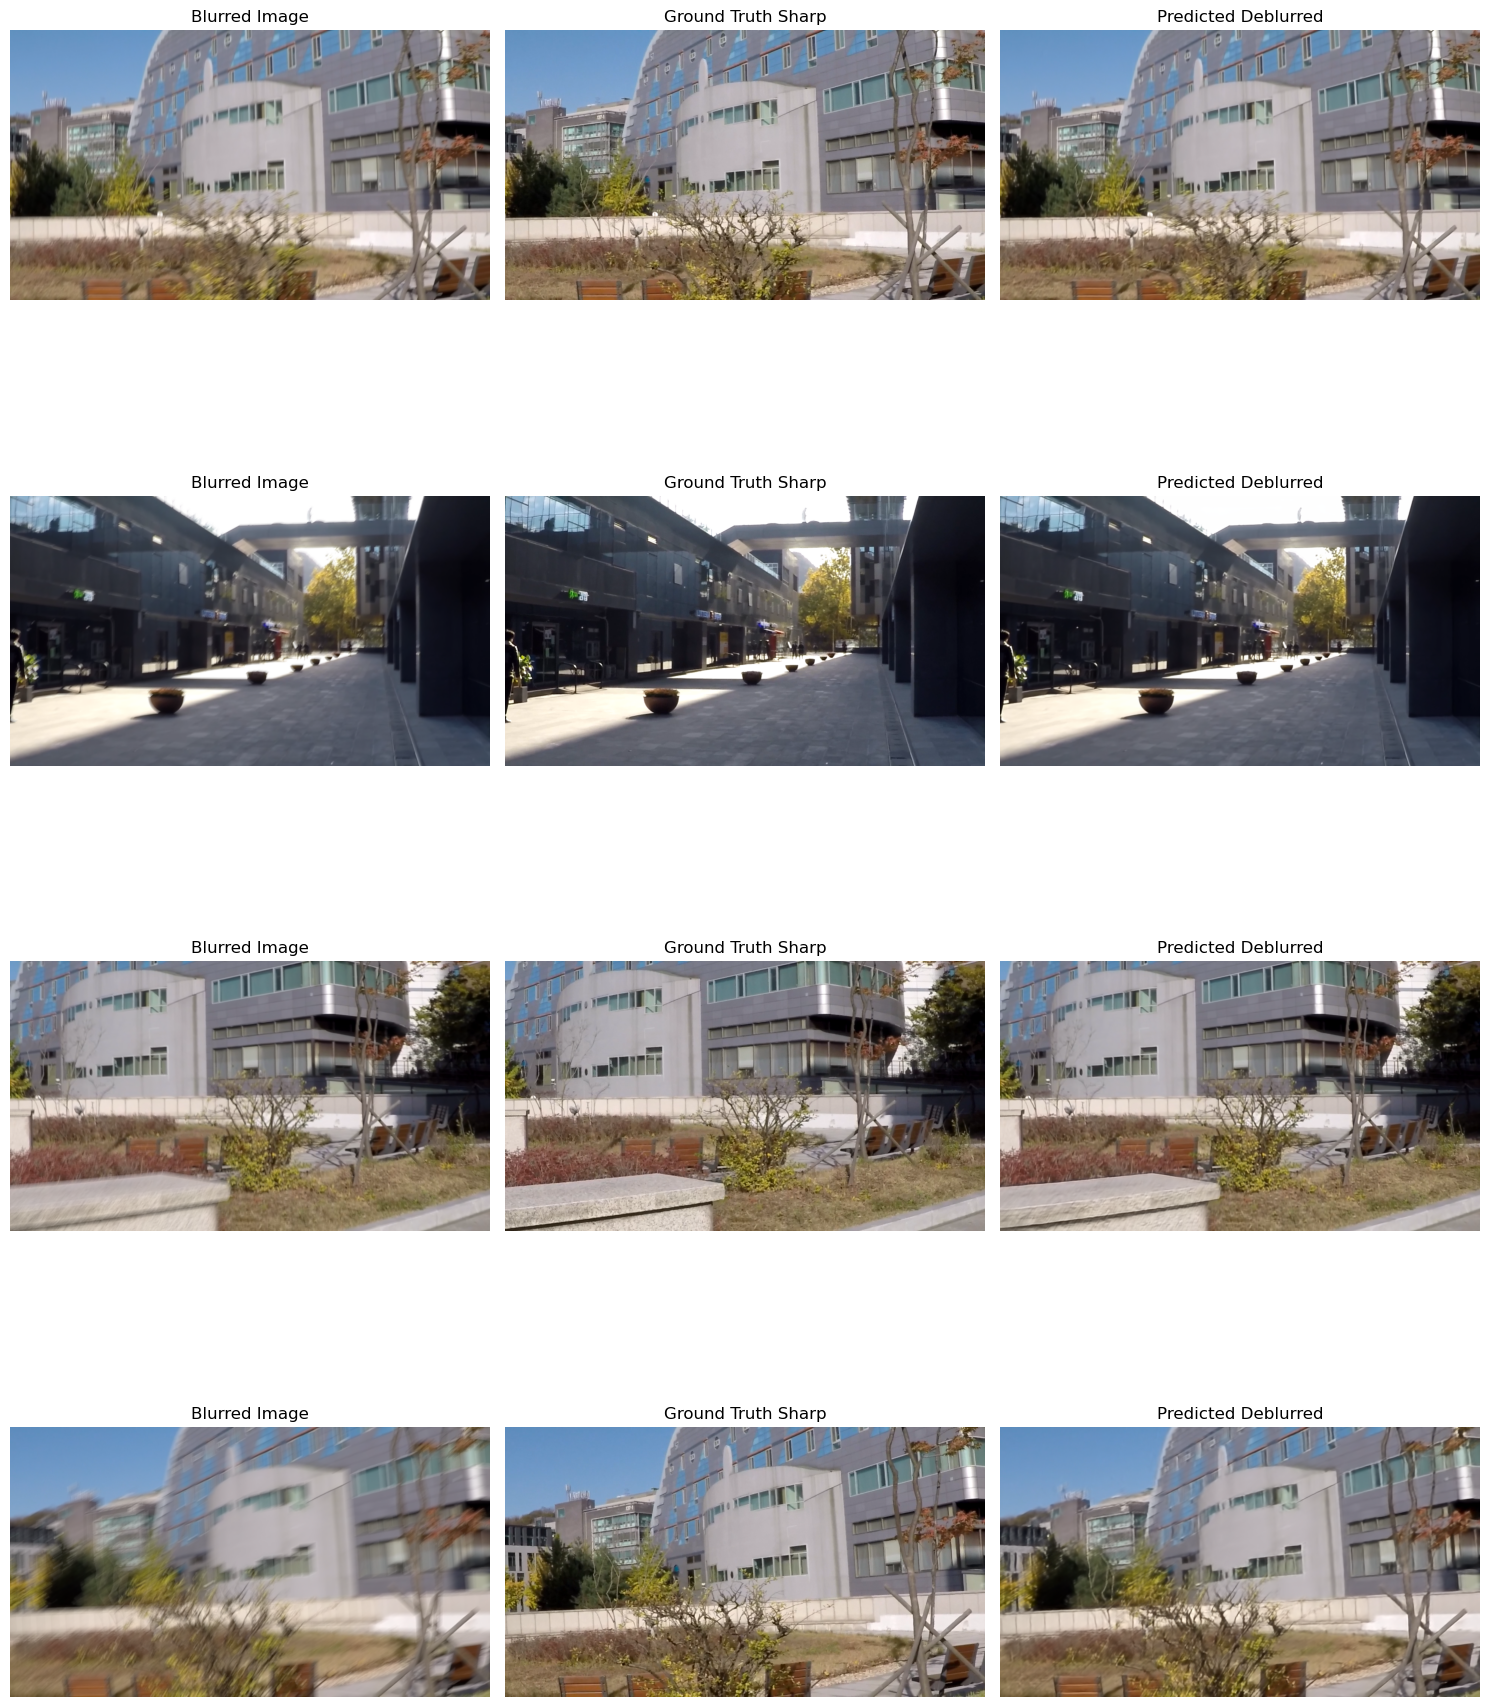

In [10]:
# Run the test
test_model(model, data_dir, batch_size)